UVE


This part performs UVE-PLS feature selection by bootstrapping PLS coefficients, selects stable features, fits a final PLS model, and evaluates/presents its predictive performance per target.


Shapes: (258, 1868) (258, 5)
Number of selected features: 1368
Selected feature indices: [   3    4    5 ... 1865 1866 1867]


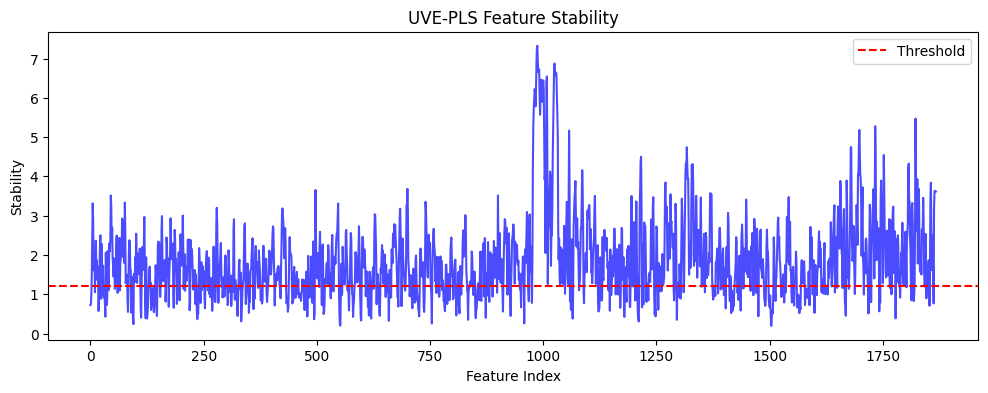

C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Optimal number of features: 1365
Indices of selected features for final PLS: [   3    4    5 ... 1861 1863 1864]
Minimum RMSE: 1018.7282072983324


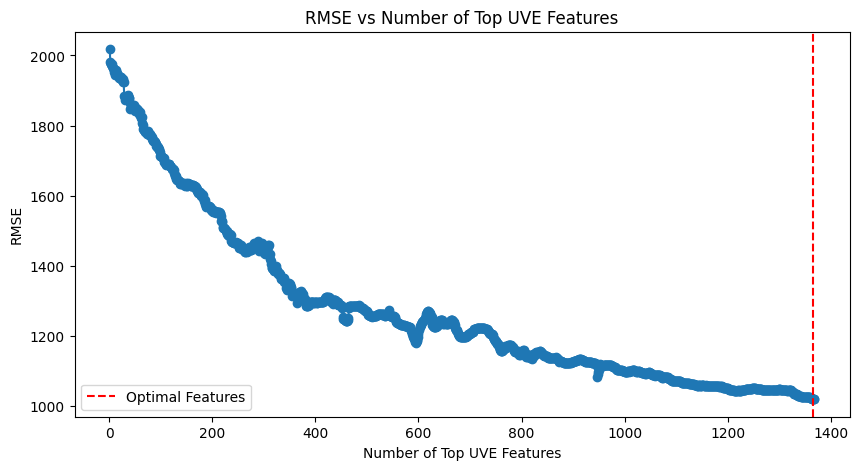

Target 1: R² = 0.7264, RMSE = 984.0048, REP% = 43.46%
Target 2: R² = 0.7704, RMSE = 1423.8162, REP% = 65.76%
Target 3: R² = 0.7228, RMSE = 703.4019, REP% = 110.49%
Target 4: R² = 0.7291, RMSE = 1303.3581, REP% = 66.05%
Target 5: R² = 0.6131, RMSE = 1.1235, REP% = 160.45%


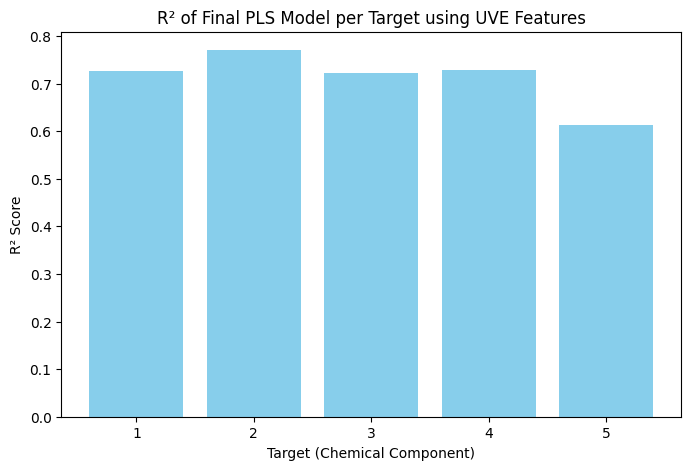

In [1]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
import matplotlib.pyplot as plt

 
X = np.loadtxt("dataF_final.csv", delimiter=",")   
Y = np.loadtxt("dataC_final.csv", delimiter=",")   

print("Shapes:", X.shape, Y.shape)

 
n_components = min(10, X.shape[0]-1)
n_iter = 50
stability_threshold = 1.2  

def uve_pls(X, Y, n_components=10, n_iter=50, stability_threshold=1.2):
    n_samples, n_features = X.shape
    n_targets = Y.shape[1]

    coef_matrix = np.zeros((n_iter, n_features, n_targets))   

    for i in range(n_iter):
        X_res, Y_res = resample(X, Y, replace=True, n_samples=n_samples)
        pls = PLSRegression(n_components=n_components)
        pls.fit(X_res, Y_res)
        
        coef = pls.coef_
         
        if coef.shape[0] != n_features:
            coef = coef.T
        coef_matrix[i] = coef

     
    mean_coef = np.mean(coef_matrix, axis=0)
    std_coef = np.std(coef_matrix, axis=0)
    stability = np.abs(mean_coef) / (std_coef + 1e-12)
    stability_max = np.max(stability, axis=1)   

    selected_idx = np.where(stability_max >= stability_threshold)[0]
    return selected_idx, stability_max

 
uve_features, stability_scores = uve_pls(X, Y, n_components=n_components, n_iter=n_iter,
                                         stability_threshold=stability_threshold)

print("Number of selected features:", len(uve_features))
print("Selected feature indices:", uve_features)

 
plt.figure(figsize=(12,4))
plt.plot(stability_scores, color='blue', alpha=0.7)
plt.axhline(y=stability_threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel("Feature Index")
plt.ylabel("Stability")
plt.title("UVE-PLS Feature Stability")
plt.legend()
plt.show()

 
X_selected = X[:, uve_features]
n_components_selected = min(n_components, X_selected.shape[1])

pls_final = PLSRegression(n_components=n_components_selected)
pls_final.fit(X_selected, Y)
Y_pred = pls_final.predict(X_selected)

 
rmse_list = []
features_list = []

for i in range(1, len(uve_features)+1):
    top_features = uve_features[:i]
    X_subset = X[:, top_features]
    pls = PLSRegression(n_components=min(n_components_selected, X_subset.shape[1]))
    pls.fit(X_subset, Y)
    Y_pred_subset = pls.predict(X_subset)
    rmse = np.sqrt(mean_squared_error(Y, Y_pred_subset))
    rmse_list.append(rmse)
    features_list.append(top_features)

 
rmse_array = np.array(rmse_list)
first_min_idx = np.argmin(rmse_array)
optimal_features = uve_features[:first_min_idx+1]

print("Optimal number of features:", len(optimal_features))
print("Indices of selected features for final PLS:", optimal_features)
print("Minimum RMSE:", rmse_array[first_min_idx])

 
plt.figure(figsize=(10,5))
plt.plot(range(1,len(rmse_list)+1), rmse_list, marker='o')
plt.axvline(x=len(optimal_features), color='red', linestyle='--', label='Optimal Features')
plt.xlabel("Number of Top UVE Features")
plt.ylabel("RMSE")
plt.title("RMSE vs Number of Top UVE Features")
plt.legend()
plt.show()

 
X_final = X[:, optimal_features]
pls_final = PLSRegression(n_components=min(n_components_selected, X_final.shape[1]))
pls_final.fit(X_final, Y)
Y_final_pred = pls_final.predict(X_final)

 
n_targets = Y.shape[1]
r2_scores, rmse_scores, rep_scores = [], [], []

for i in range(n_targets):
    y_true = Y[:, i]
    y_pred = Y_final_pred[:, i]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rep = (rmse / np.mean(y_true))*100 if np.mean(y_true)!=0 else np.nan
    r2 = r2_score(y_true, y_pred)
    rmse_scores.append(rmse)
    rep_scores.append(rep)
    r2_scores.append(r2)
    print(f"Target {i+1}: R² = {r2:.4f}, RMSE = {rmse:.4f}, REP% = {rep:.2f}%")

 
plt.figure(figsize=(8,5))
plt.bar(range(1,n_targets+1), r2_scores, color='skyblue')
plt.xlabel("Target (Chemical Component)")
plt.ylabel("R² Score")
plt.title("R² of Final PLS Model per Target using UVE Features")
plt.show()


Here we fit Ridge, Lasso, and ElasticNet regression models on UVE-selected features, evaluated their performance per target, and visualized the R² scores.


Ridge - Best alpha: 100
Ridge - Target 1: R²=0.9461, RMSE=436.5768, REP%=19.28%
Ridge - Target 2: R²=0.9491, RMSE=670.6273, REP%=30.97%
Ridge - Target 3: R²=0.9515, RMSE=294.0886, REP%=46.20%
Ridge - Target 4: R²=0.9423, RMSE=601.4496, REP%=30.48%
Ridge - Target 5: R²=0.9221, RMSE=0.5041, REP%=71.99%


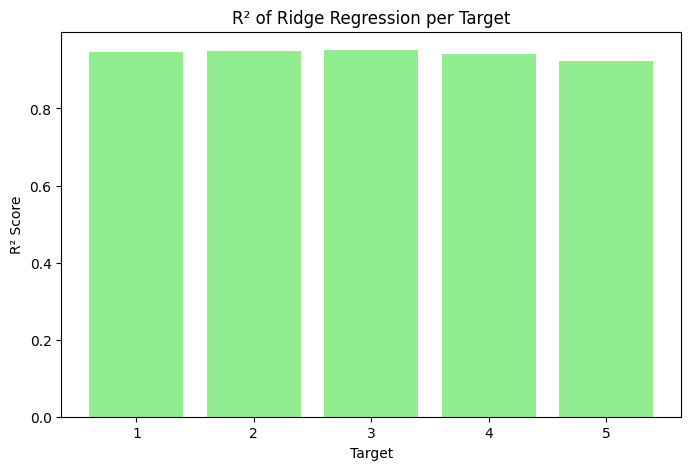

C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.475e+05, tolerance: 9.129e+04
  model = cd_fast.enet_coordinate_descent(


Lasso - Target 1: R²=0.9547, RMSE=400.4133, REP%=17.68%


C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.175e+05, tolerance: 2.278e+05
  model = cd_fast.enet_coordinate_descent(


Lasso - Target 2: R²=0.9760, RMSE=460.3482, REP%=21.26%


C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.112e+04, tolerance: 4.605e+04
  model = cd_fast.enet_coordinate_descent(


Lasso - Target 3: R²=0.9452, RMSE=312.8790, REP%=49.15%
Lasso - Target 4: R²=0.9702, RMSE=432.5776, REP%=21.92%
Lasso - Target 5: R²=0.0000, RMSE=1.8062, REP%=257.94%


C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.829e+05, tolerance: 1.618e+05
  model = cd_fast.enet_coordinate_descent(


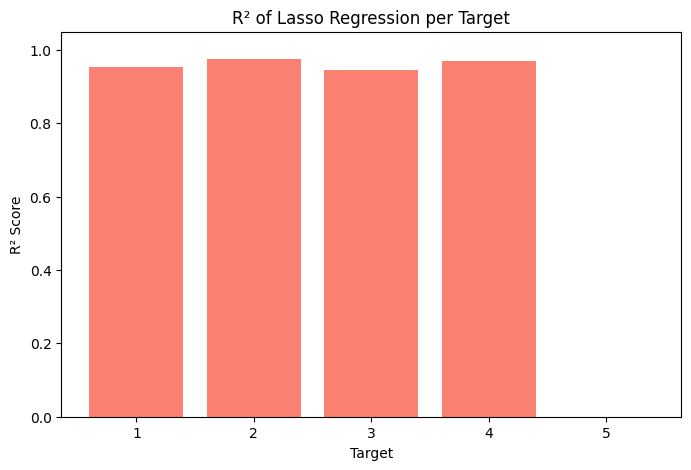

C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.658e+06, tolerance: 9.129e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.701e+06, tolerance: 2.278e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

ElasticNet - Target 1: R²=0.9998, RMSE=23.0800, REP%=1.02%
ElasticNet - Target 2: R²=0.9991, RMSE=91.4159, REP%=4.22%
ElasticNet - Target 3: R²=1.0000, RMSE=8.0813, REP%=1.27%
ElasticNet - Target 4: R²=0.9991, RMSE=76.8256, REP%=3.89%
ElasticNet - Target 5: R²=0.9900, RMSE=0.1809, REP%=25.84%


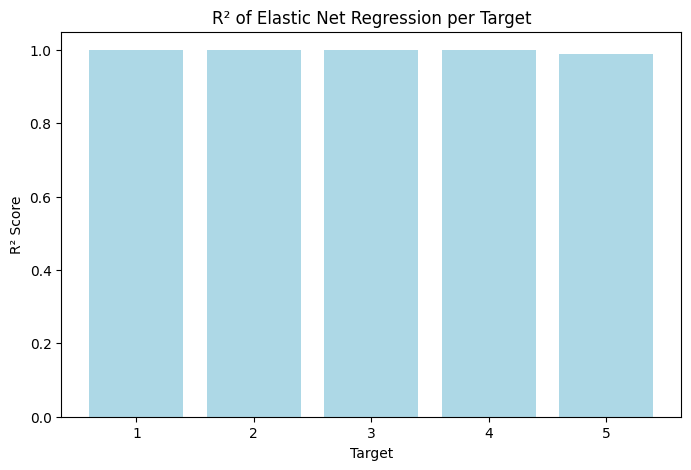

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

 
X_final = X[:, optimal_features]   
Y_final = Y

 
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_final)

 
Y_mean = np.mean(Y_final, axis=0)
Y_std = np.std(Y_final, axis=0)
Y_scaled = (Y_final - Y_mean) / Y_std

 
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_cv = GridSearchCV(Ridge(), param_grid={'alpha': alphas}, cv=5, scoring='r2')
ridge_cv.fit(X_scaled, Y_scaled)
best_alpha = ridge_cv.best_params_['alpha']
print("Ridge - Best alpha:", best_alpha)

 
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_scaled, Y_scaled)
Y_pred_scaled = ridge_model.predict(X_scaled)
Y_pred_ridge = Y_pred_scaled * Y_std + Y_mean

 
r2_list, rmse_list, rep_list = [], [], []
for i in range(Y_final.shape[1]):
    y_true = Y_final[:, i]
    y_pred = Y_pred_ridge[:, i]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rep = (rmse / np.mean(y_true)) * 100 if np.mean(y_true) != 0 else np.nan
    r2 = r2_score(y_true, y_pred)
    r2_list.append(r2)
    rmse_list.append(rmse)
    rep_list.append(rep)
    print(f"Ridge - Target {i+1}: R²={r2:.4f}, RMSE={rmse:.4f}, REP%={rep:.2f}%")

plt.figure(figsize=(8,5))
plt.bar(range(1,Y_final.shape[1]+1), r2_list, color='lightgreen')
plt.xlabel("Target")
plt.ylabel("R² Score")
plt.title("R² of Ridge Regression per Target")
plt.show()

 
r2_list, rmse_list, rep_list = [], [], []

for i in range(Y_final.shape[1]):
    y_true = Y_final[:, i]
    lasso = Lasso(alpha=0.01, max_iter=10000)
    lasso.fit(X_final, y_true)
    y_pred = lasso.predict(X_final)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rep = (rmse / np.mean(y_true)) * 100 if np.mean(y_true) != 0 else np.nan
    r2 = r2_score(y_true, y_pred)
    
    r2_list.append(r2)
    rmse_list.append(rmse)
    rep_list.append(rep)
    
    print(f"Lasso - Target {i+1}: R²={r2:.4f}, RMSE={rmse:.4f}, REP%={rep:.2f}%")

plt.figure(figsize=(8,5))
plt.bar(range(1,Y_final.shape[1]+1), r2_list, color='salmon')
plt.xlabel("Target")
plt.ylabel("R² Score")
plt.title("R² of Lasso Regression per Target")
plt.ylim(0,1.05)
plt.show()

 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

elastic_model = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=5000)
Y_pred_en = np.zeros_like(Y_final)

for i in range(Y_final.shape[1]):
    y_true = Y_final[:, i]
    elastic_model.fit(X_scaled, y_true)
    Y_pred_en[:, i] = elastic_model.predict(X_scaled)

r2_list, rmse_list, rep_list = [], [], []
for i in range(Y_final.shape[1]):
    y_true = Y_final[:, i]
    y_pred = Y_pred_en[:, i]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rep = (rmse / np.mean(y_true)) * 100 if np.mean(y_true) != 0 else np.nan
    r2 = r2_score(y_true, y_pred)
    r2_list.append(r2)
    rmse_list.append(rmse)
    rep_list.append(rep)
    
    print(f"ElasticNet - Target {i+1}: R²={r2:.4f}, RMSE={rmse:.4f}, REP%={rep:.2f}%")

plt.figure(figsize=(8,5))
plt.bar(range(1,Y_final.shape[1]+1), r2_list, color='lightblue')
plt.xlabel("Target")
plt.ylabel("R² Score")
plt.title("R² of Elastic Net Regression per Target")
plt.ylim(0,1.05)
plt.show()
